In [1]:
#Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, integrate
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
aisles = pd.DataFrame.from_csv('aisles.csv', index_col=None)
aisles.head(10)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [3]:
orders = pd.DataFrame.from_csv('orders.csv', index_col=None)
orders.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [4]:
products = pd.DataFrame.from_csv('products.csv', index_col=None)
products.head(10)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [5]:
prior_orders = pd.DataFrame.from_csv('order_products__prior.csv', index_col=None)
prior_orders.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [6]:
departments = pd.DataFrame.from_csv('departments.csv', index_col=None)
departments.head(19)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


Hypothesis 1: new users that don't reorder in 7 days have very low probability of reordering<br>
Hypothesis 2: Gauge the correlation between days since prior order and number of items bought<br>
Hypothesis 3: Customers who buy the same items 5 times in a row will order the same items in the future<br>
Hypothesis 4: Probability of customers ordering junk food is higher at night than during the day<br>
Hypothesis 4: Somebody that buys milk likely to buy cereal

Set tests: organic and disorganic
If someone buys organic avocados probably buy lime


# Statistical Analysis

<b> Ho = An order with an organic produce is likely to have inorganic produce as well</b> <br>
<b> Ha = An order with an organic produce likely to have all organic produce</b>

In [7]:
priorOrders_copy = prior_orders
products_copy = products
merged_table = priorOrders_copy.merge(products_copy)

In [8]:
filtered_table = merged_table.loc[merged_table['department_id'].isin([4])]

In [9]:
filtered_table['all_organic'] = filtered_table.product_name.str.contains("Organic")

/Users/atuladhikari/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
filtered_table2 = filtered_table[['order_id','product_name','all_organic']]
filtered_table2=filtered_table2.groupby(['order_id']).agg({'all_organic':'mean'}).reset_index()
filtered_table2 = filtered_table2[filtered_table2.all_organic != 0]

In [11]:
n = len(filtered_table2)
all_organic = len(filtered_table2[filtered_table2.all_organic == 1])
prob_allOrganic = all_organic/n
prob_notOrganic = 1-prob_allOrganic
print ("Probability all produce items are organic:", prob_allOrganic)
print ("Probability that not all produce items are organic:", prob_notOrganic)

Probability all produce items are organic: 0.30945654410057877
Probability that not all produce items are organic: 0.6905434558994212


In [12]:
z_stat = (prob_allOrganic-0)/np.sqrt(prob_allOrganic*prob_notOrganic)
p_value = stats.norm.sf(abs(z_stat))
print ("p-value:",p_value)

p-value: 0.25161102399


Null hypothesis cannot be rejected because p-value of 0.25 is way more than the significance level of 0.05

<b>Correlation between number of items bought and days since prior order</b>

In [13]:
orders_copy = orders.dropna()
orders_copy_merge = orders_copy.merge(prior_orders)

In [14]:
orders_copy2_merge = orders_copy_merge
orders_copy_filter = orders_copy2_merge[['order_id', 'product_id','days_since_prior_order']]

In [15]:
temp = orders_copy_filter
temp = temp.groupby('order_id', sort=False)\
  .agg({'product_id': 'size','days_since_prior_order': 'min'})

In [16]:
avg_orderCount = temp 
avg_orderCount = temp.groupby(['product_id'])\
    .agg({'days_since_prior_order':'mean'})
avg_orderCount = avg_orderCount.reset_index()

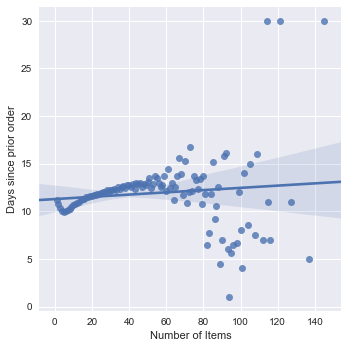

In [17]:
import seaborn as sns
sns.lmplot(x='product_id', y='days_since_prior_order', data=avg_orderCount)
plt.xlabel("Number of Items")
plt.ylabel("Days since prior order")

In [18]:
# avg_orderCount['product_id'].corr(avg_orderCount['days_since_prior_order'])
pearsonr(avg_orderCount['product_id'],avg_orderCount['days_since_prior_order'])

(0.10280921213824219, 0.27854224924766502)

Since the p-value of the correlation coefficient is 0.28, which is much higher than a significance level of 0.05, the correlation is <b>not significant</b>. The correlation coefficient is very small as well, indicating there is not a strong relationship. The outliers also need to be accounted for to get a better picture of the correlation.

Even though the p-value and correlation coefficient showed that there is not a strong linear relationship, the scatter plot does seem to show that there is a linear relationship until the first 50 items. Let's check that. 

Observed pearson corr coef and p value: (0.94827118496953111, 1.453192875864056e-25)


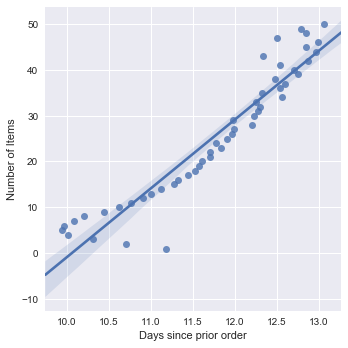

In [22]:
avg_orderCount=avg_orderCount.rename(columns={"product_id":"no_items"})
avg_orderCount = avg_orderCount.loc[avg_orderCount['no_items']<=50]
sns.lmplot(y='no_items', x='days_since_prior_order', data=avg_orderCount)
plt.ylabel("Number of Items")
plt.xlabel("Days since prior order")
obs_pearson = pearsonr(avg_orderCount['no_items'],avg_orderCount['days_since_prior_order'])
print ("Observed pearson corr coef and p value:",obs_pearson)

As seen in the plot above and the values of the correlation coefficient (0.95) and the p-value(1.45e-25), we can say with certainty that there is a linear relationship between numnber of items ordered and days since prior order until 50 items ordered. 

In [80]:
#Testing p-value significance using permutation method:

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

for i in range(10000):
    avg_orderCount['no_items'] = np.random.permutation(avg_orderCount['no_items'])

    # Compute Pearson correlation
    perm_replicates[i] = avg_orderCount['no_items'].corr(avg_orderCount['days_since_prior_order'])


p_val = np.sum(perm_replicates>=obs_pearson[0])/len(perm_replicates)
print ("p_value:", p_val)

p_value: 0.0


<b>H0: Orders with milk not likely to contain cereal <br>
Ha: Orders with milk likely to contain cereal
</b>

In [29]:
priorOrders_copy = prior_orders
products_copy = products
merged_table = priorOrders_copy.merge(products_copy)

In [22]:
filtered_table = merged_table.loc[merged_table['department_id'].isin([16,14])]

In [23]:
filtered_table['milk'] = filtered_table.product_name.str.contains("Milk")
filtered_table['cereal'] = filtered_table.product_name.str.contains("Cereal")

/Users/atuladhikari/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/atuladhikari/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
filtered_table2=filtered_table.loc[filtered_table['milk']==True]
filtered_table2 = filtered_table2[['order_id','product_name','milk','cereal']]

In [25]:
filtered_table2=filtered_table2.groupby(['order_id']).agg({'milk':'max','cereal':'sum'}).reset_index()

In [ ]:
len(filtered_table2[filtered_table2['cereal']]==True)

0

None of the orders that included milk contained a cereal as well, thus cannot conduct the hypothesis test. 

<b>H0 = No relationship between order day of week and number of items ordered </b><br>
<b>Ha = People that order during the weekend are likely to order more than people that order during the weekday</b>
Motivation: When I do groceries during the weekends, I tend to plan it for the week and buy everything I would need for the weekday. However, when I do groceries during the weekdays, it's mostly because I ran out of something and need it for the rest of the week. 

In [225]:
orders_copy = orders
orders_prior = orders.merge(prior_orders)

In [226]:
orders_prior = orders_prior[['order_id','order_dow','product_id']]

In [227]:
orders_prior = orders_prior.groupby(['order_id','order_dow']).agg({'product_id':'count'}).reset_index()

In [228]:
orders_prior = orders_prior.rename(columns={"product_id":"no_items"})
# obs_pearson = pearsonr(avg_orderCount['no_items'],avg_orderCount['days_since_prior_order'])
# print ("Observed pearson corr coef and p value:",obs_pearson)

([<matplotlib.axis.XTick at 0x11ce2c4a8>,
 <a list of 7 Text xticklabel objects>)

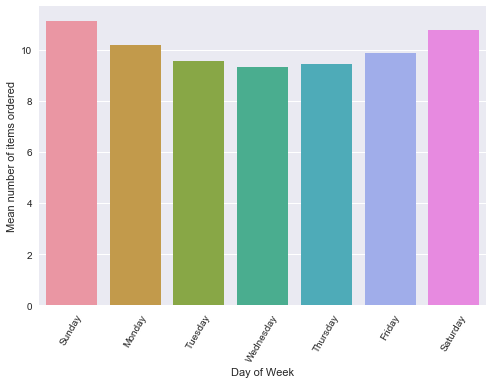

In [161]:
orders_prior2= orders_prior.groupby('order_dow').agg({'no_items':'mean'}).reset_index()
sns.barplot(x='order_dow',y='no_items',data=orders_prior2)
plt.xlabel('Day of Week')
plt.ylabel('Mean number of items ordered')
plt.xticks( np.arange(7), ('Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday'),rotation=60 )

From the plot above, we see that the mean number of items bought on Saturday and Sunday is higher than the number of items bought other days of the week. But is it significant? Let's do a hypothesis test:

In [162]:
sat_sun = orders_prior2.loc[orders_prior2['order_dow'].isin([0,6])].mean()[1]
weekday = orders_prior2.loc[orders_prior2['order_dow'].isin([1,2,3,4,5])].mean()[1]
diff_actual = sat_sun - weekday
print ("Actual Observed Difference: ", diff_actual)

Actual Observed Difference:  1.26599092042


In [313]:
#Bootstrap Test
orders_prior_copy = orders_prior
diff_temp = np.empty(50)

In [316]:
for i in range(50):
    orders_prior_copy['no_items'] = np.random.choice(orders_prior_copy['no_items'],size=len(orders_prior_copy))
    x=y = orders_prior_copy
    sat_sun_temp = y.loc[y['order_dow'].isin([0,6])].mean()[2]
    weekday_temp = x.loc[x['order_dow'].isin([1,2,3,4,5])].mean()[2]
    diff_temp[i] = sat_sun_temp-weekday_temp

p_val = np.sum(diff_temp>=diff_actual)/len(diff_temp)
print ("p_value:", p_val)

p_value: 0.0


Since the p-value is so low, we can reject the null hypothesis that there is no difference between the number of items that were ordered in the weekend vs the weekdays. I only ran 50 simulations because the for loop is computationally intensive but the result should be similar. In summary, <b>individuals order more items in weekends than in weekdays.</b>